In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import string
from sklearn.model_selection import train_test_split


In [4]:
csv_file_path = './airbnb_dataset/data_loo.csv'
df = pd.read_csv(csv_file_path)
pd.set_option('display.max_columns', None)
df.head()

,log_price,accommodates,bathrooms,host_response_rate,bedrooms,beds,property_type_encoded,room_type_encoded,bed_type_encoded,cancellation_policy_encoded,city_encoded,cleaning_fee_encoded,host_has_profile_pic_encoded,des_sentiment_analysis,name_sentiment_analysis
0,5.010635,-0.072621,-0.404046,0.296013,-0.312048,-0.566461,-0.245313,0.876836,0.168067,1.021281,-0.434017,0.601859,-0.055693,0.216242,-0.435248
1,5.129899,1.783653,-0.404046,0.296013,2.034955,1.027816,-0.245338,0.876830,0.168044,1.021245,-0.434042,0.601832,-0.055864,0.837002,-1.788095
2,4.976734,0.855516,-0.404046,0.296013,-0.312048,1.027816,-0.245305,0.876838,0.168074,-0.593873,-0.434009,0.601867,-0.055644,0.808508,-0.133695
3,6.620073,0.391448,-0.404046,0.296013,0.861454,0.230678,0.157557,0.876747,0.167757,-1.013554,2.675098,0.601488,-0.058002,0.213627,-0.926212
4,4.744932,-0.536689,-0.404046,0.296013,-1.485549,-0.566461,-0.245255,0.876851,0.168119,-0.593754,1.412368,0.601920,-0.055312,-0.101872,-0.095776


In [5]:
features = [col for col in df.columns if col != 'log_price' and df[col].dtype in ['int64', 'float64']]
X = df[features]
y = df['log_price']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [6]:
def metrics(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred):
    # Training metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Validation metrics
    mse_val = mean_squared_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)

    # Testing metrics
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

   # Print the metrics
    print("Training Metrics:")
    print(f"MSE: {mse_train}, RMSE: {rmse_train}, MAE: {mae_train}, R2: {r2_train}")

    print("Validation Metrics:")
    print(f"MSE: {mse_val}, RMSE: {rmse_val}, MAE: {mae_val}, R2: {r2_val}")

    print("Testing Metrics:")
    print(f"MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}, R2: {r2_test}")

    return mse_test, rmse_test, mae_test, r2_test

## 2nd Polynomial Regression

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.pipeline import make_pipeline
import plotly.graph_objects as go
import plotly.express as px


In [8]:
degree=2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)
poly_y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

metrics_pr=metrics(y_train, y_train_pred, y_val, poly_y_val_pred, y_test, y_test_pred)

Training Metrics:
MSE: 0.18089841971130352, RMSE: 0.42532154860917115, MAE: 0.3200939064365524, R2: 0.647576263129637
Validation Metrics:
MSE: 0.18009610113292734, RMSE: 0.42437730987050587, MAE: 0.3204469941776878, R2: 0.6454864820784412
Testing Metrics:
MSE: 0.1863623277234035, RMSE: 0.4316970323310128, MAE: 0.3236178648455609, R2: 0.6452324338338177


## Neual Network

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras_tuner
import keras
import tensorflow as tf

nn_model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dense(16, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
history_nn = nn_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val),verbose=0)
mse_nn = nn_model.evaluate(X_test, y_test)
print(f"Mean Squared Error on Test Set: {mse_nn}")

463/463 [==============================] - 0s 579us/step - loss: 0.1968
Mean Squared Error on Test Set: 0.19679319858551025


### Hyperparameter Tuning

In [11]:
def build_hp_model(hp):
    model = Sequential()
    # Iterate over the number of layers
    for i in range(hp.Int('num_layers', 2, 6)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=16, max_value=96, step=16),
                        activation=hp.Choice('activation_' + str(i), ['leaky_relu'])))
    
    model.add(Dense(1))  # Output layer for regression
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    return model

In [12]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    mode='min',
    restore_best_weights=True,
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only= False,
    mode='min'
)
tuner = keras_tuner.RandomSearch(
    hypermodel=build_hp_model,
    objective='val_loss',
    max_trials=8,
    seed=10,
    executions_per_trial=3,
    directory='tuner_results',
    project_name='keras_tuner_demo',
    overwrite=True
)

In [13]:
tuner_search = tuner.search(X_train, y_train, epochs=20, callbacks=[early_stopping, model_checkpoint], validation_data=(X_val, y_val))

Trial 8 Complete [00h 01m 15s]
val_loss: 0.19097788135210672

Best val_loss So Far: 0.1894183208545049
Total elapsed time: 00h 08m 27s


In [14]:
best_model = keras.models.load_model('best_model.h5')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
nn_y_val_pred = best_model.predict(X_val)

metrics_nn=metrics(y_train, y_train_pred, y_val, nn_y_val_pred, y_test, y_test_pred)

463/463 [==============================] - 0s 391us/step
Training Metrics:
MSE: 0.18822474649243134, RMSE: 0.43384875992957656, MAE: 0.32597222564128947, R2: 0.6333032171524579
Validation Metrics:
MSE: 0.1910797776736691, RMSE: 0.4371267295346615, MAE: 0.32829314782596375, R2: 0.6238654598260115
Testing Metrics:
MSE: 0.1960248799052123, RMSE: 0.4427469705206489, MAE: 0.33200554149332834, R2: 0.6268383723173625


In [22]:
def plot_metrics(history, test_loss, modelName = 'Model' ,ax = None, save = False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.plot(history.history['loss'], label='Train Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    
    best_epoch = np.argmin(history.history['val_loss'])
    best_val_loss = np.min(history.history['val_loss'])

    ax.scatter(best_epoch, best_val_loss, color='green', s=100, marker='o', label='Best Epoch')

    ax.hlines(test_loss, 0, len(history.history['loss']) - 1, colors='red', linestyles='dashed', label='Test Loss')

    ax.set_title(f'{modelName} Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    ax.grid(True)
    ax.set_ylim(0.18 , 0.25)
    
    if save:
      plt.savefig(f'graphs/loss.jpg')

In [23]:
history_best = best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),verbose=0)
test_loss_best = best_model.evaluate(X_test, y_test)[0]
y_pred = best_model.predict(X_test)

463/463 [==============================] - 0s 384us/step


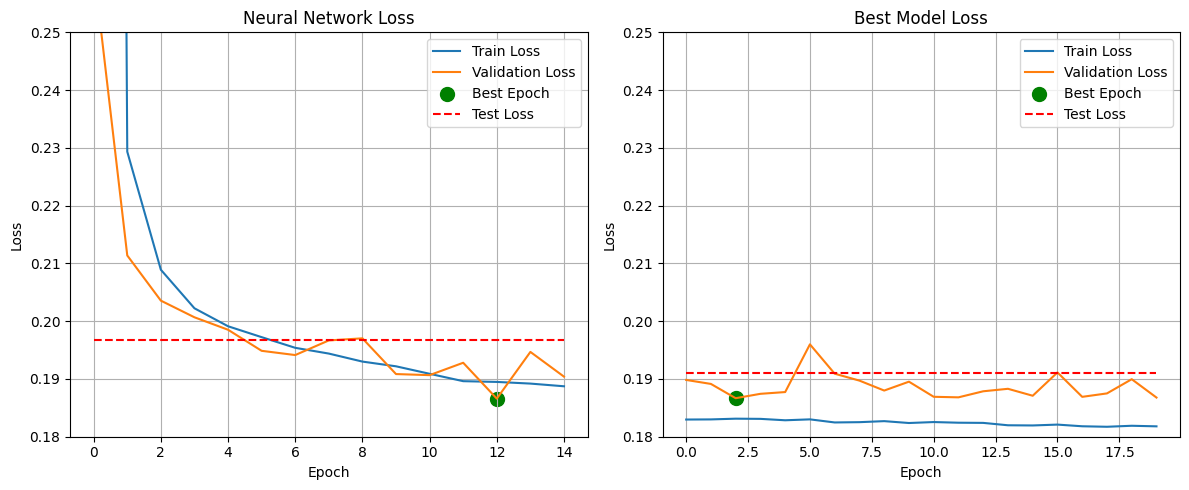

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_metrics(history_nn, mse_nn, modelName='Neural Network', ax = axs[0])
plot_metrics(history_best, test_loss_best, modelName = 'Best Model', ax = axs[1], save = True)
plt.tight_layout()
plt.show()

## XGboost

In [19]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'eta': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
}

fit_params={"early_stopping_rounds":20, 
            "eval_metric" : "rmse", 
             "eval_set": [(X_val, y_val)]}
    
xgb_model = xgb.XGBRegressor(n_estimators=250, random_state=42,objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=False)

grid_search.fit(X_train_full, y_train_full,verbose=False)

# Retrieve the best model
best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Best parameters found: ", grid_search.best_params_)
print("Train MSE: ", mse_train)
print("Test MSE: ", mse_test)

Best parameters found:  {'colsample_bytree': 0.9, 'eta': 0.1, 'max_depth': 5, 'subsample': 0.9}
Train MSE:  4.339220351424016e-05
Test MSE:  0.00021548211188598474


In [20]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
xgb_y_val_pred = best_model.predict(X_val)

metrics_xgb=metrics(y_train, y_train_pred, y_val, xgb_y_val_pred, y_test, y_test_pred)

Training Metrics:
MSE: 4.339220351424016e-05, RMSE: 0.006587275879621269, MAE: 0.002899503642276942, R2: 0.9999154639242402
Validation Metrics:
MSE: 4.6099613551444094e-05, RMSE: 0.006789669620198327, MAE: 0.0029196482242680676, R2: 0.9999092543587998
Testing Metrics:
MSE: 0.00021548211188598474, RMSE: 0.01467930897167795, MAE: 0.00372147847078662, R2: 0.9995897987253111


## Result

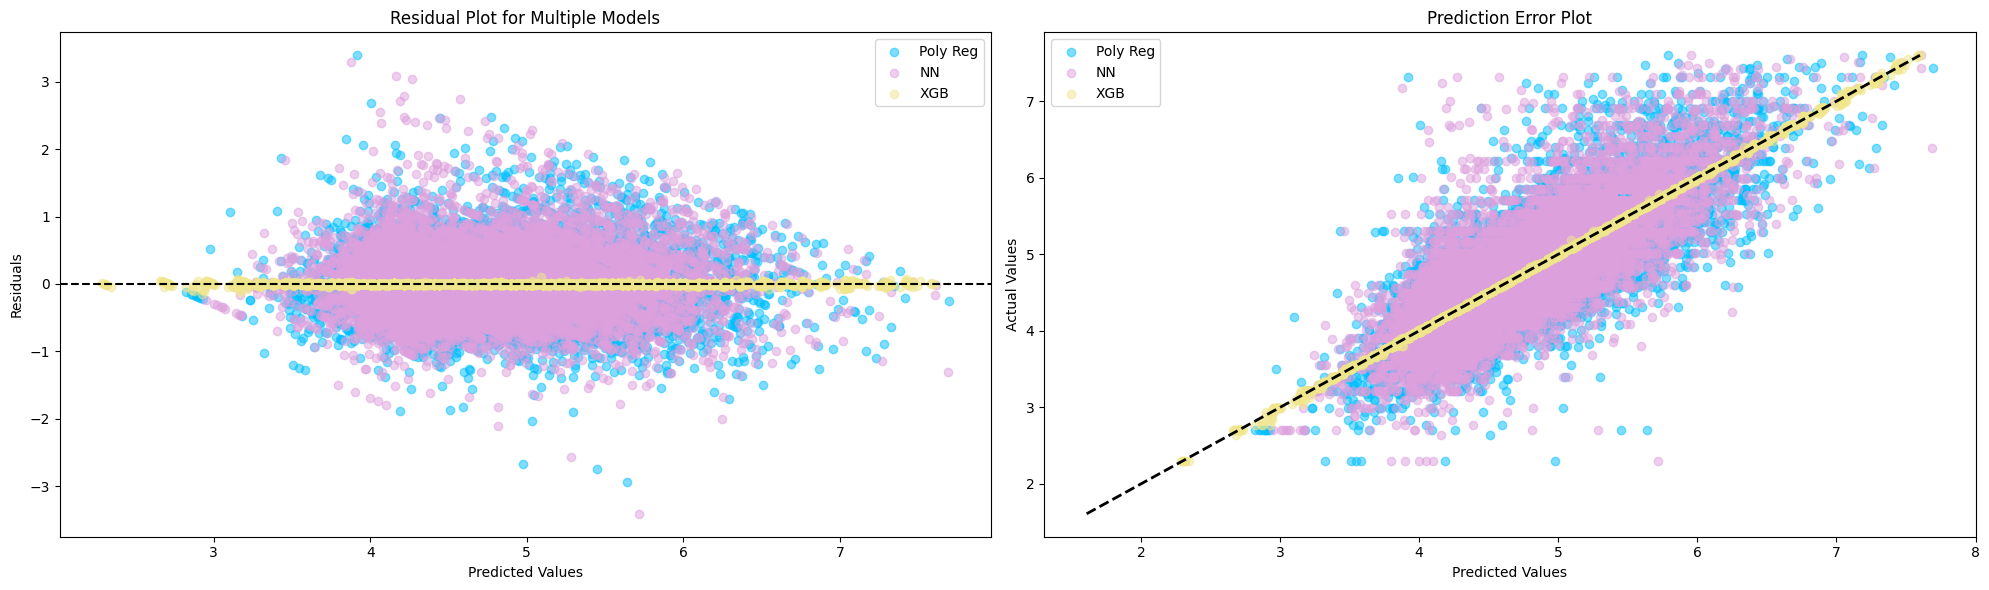

In [21]:
residuals_val1 = y_val - poly_y_val_pred.flatten()
residuals_val2 = y_val - nn_y_val_pred.flatten()
residuals_val3 = y_val - xgb_y_val_pred.flatten()

# Set up the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Residual Plot for multiple models
ax1.scatter(poly_y_val_pred, residuals_val1, alpha=0.5, label='Poly Reg', color='DeepSkyBlue')
ax1.scatter(nn_y_val_pred, residuals_val2, alpha=0.5, label='NN', color='Plum')
ax1.scatter(xgb_y_val_pred, residuals_val3, alpha=0.5, label='XGB', color='Khaki')
ax1.set_title('Residual Plot for Multiple Models')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Residuals')
ax1.legend()
ax1.axhline(y=0, color='black', linestyle='--')

# Prediction Error Plot
ax2.scatter(poly_y_val_pred, y_val, alpha=0.5, label='Poly Reg', color='DeepSkyBlue')
ax2.scatter(nn_y_val_pred, y_val, alpha=0.5, color='Plum', label='NN')
ax2.scatter(xgb_y_val_pred, y_val, alpha=0.5, label='XGB', color='Khaki')


all_data_range = [min(min(y_val), min(y_test)), max(max(y_val), max(y_test))]
ax2.plot(all_data_range, all_data_range, 'k--', lw=2)
ax2.set_title('Prediction Error Plot')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

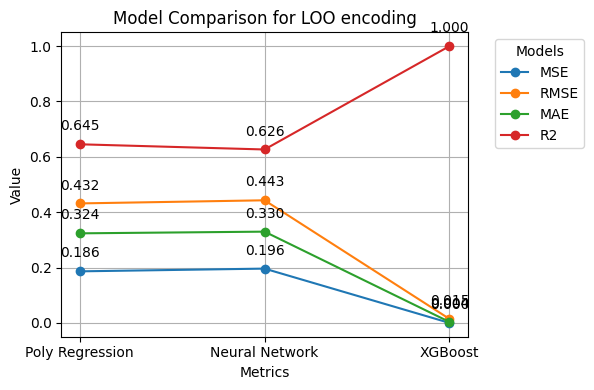

In [22]:
data = {
    'Model': ['Poly Regression', 'Neural Network', 'XGBoost'],
    'MSE': [metrics_pr[0], metrics_nn[0], metrics_xgb[0]],
    'RMSE': [metrics_pr[1], metrics_nn[1], metrics_xgb[1]],
    'MAE': [metrics_pr[2], metrics_nn[2], metrics_xgb[2]],
    'R2': [metrics_pr[3], metrics_nn[3], metrics_xgb[3]]
}

results_df = pd.DataFrame(data)
results_df.set_index('Model', inplace=True)

ax = results_df.plot(kind='line', marker='o', figsize=(5, 4))
ax.set_title('Model Comparison for LOO encoding')
ax.set_ylabel('Value')
ax.set_xlabel('Metrics')
plt.xticks(ticks=range(len(results_df.index)), labels=results_df.index, rotation=0)
plt.tight_layout()
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
for i in ax.get_lines():
    for x, y in zip(i.get_xdata(), i.get_ydata()):
        label = "{:.3f}".format(y)
        ax.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')
plt.grid(True)
plt.show()